In [4]:
my_data=[['slashdot','USA','yes',18,'None'],
        ['google','France','yes',23,'Premium'],
        ['digg','USA','yes',24,'Basic'],
        ['kiwitobes','France','yes',23,'Basic'],
        ['google','UK','no',21,'Premium'],
        ['(direct)','New Zealand','no',12,'None'],
        ['(direct)','UK','no',21,'Basic'],
        ['google','USA','no',24,'Premium'],
        ['slashdot','France','yes',19,'None'],
        ['digg','USA','no',18,'None'],
        ['google','UK','no',18,'None'],
        ['kiwitobes','UK','no',19,'None'],
        ['digg','New Zealand','yes',12,'Basic'],
        ['slashdot','UK','no',21,'None'],
        ['google','UK','yes',18,'Basic'],
        ['kiwitobes','France','yes',19,'Basic']]

In [5]:
def divideset(rows, column, value):
    split_f = None
    if isinstance(value, int) or isinstance(value, float):
        split_f = lambda row: row[column]>=value
    else:
        split_f = lambda row: row[column]==value
    set1 = [row for row in rows if split_f(row)]
    set2 = [row for row in rows if not split_f(row)]
    return (set1, set2)

In [6]:
divideset(my_data, 0, 'google')

([['google', 'France', 'yes', 23, 'Premium'],
  ['google', 'UK', 'no', 21, 'Premium'],
  ['google', 'USA', 'no', 24, 'Premium'],
  ['google', 'UK', 'no', 18, 'None'],
  ['google', 'UK', 'yes', 18, 'Basic']],
 [['slashdot', 'USA', 'yes', 18, 'None'],
  ['digg', 'USA', 'yes', 24, 'Basic'],
  ['kiwitobes', 'France', 'yes', 23, 'Basic'],
  ['(direct)', 'New Zealand', 'no', 12, 'None'],
  ['(direct)', 'UK', 'no', 21, 'Basic'],
  ['slashdot', 'France', 'yes', 19, 'None'],
  ['digg', 'USA', 'no', 18, 'None'],
  ['kiwitobes', 'UK', 'no', 19, 'None'],
  ['digg', 'New Zealand', 'yes', 12, 'Basic'],
  ['slashdot', 'UK', 'no', 21, 'None'],
  ['kiwitobes', 'France', 'yes', 19, 'Basic']])

In [7]:
def unique_counts(rows):
    results = {}
    for row in rows:
        r = row[-1]
        if r not in results: results[r]=0
        results[r]+=1
    return results

In [8]:
unique_counts(my_data)

{'Basic': 6, 'None': 7, 'Premium': 3}

In [9]:
unique_counts(divideset(my_data, 0, "google")[0])

{'Basic': 1, 'None': 1, 'Premium': 3}

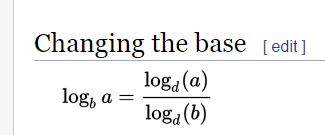

In [10]:
from IPython.display import Image
Image(filename="logbase.PNG")

In [11]:
from math import log
def entropy(rows):
    log2 = lambda x: log(x)/log(2)
    results = unique_counts(rows)
    ent = 0.0
    for k,v in results.items():
        p = float(v)/len(rows)
        ent = ent - p*log2(p)
    return ent

In [12]:
set1, set2 = divideset(my_data, 3, 20)
entropy(set1), entropy(set2)

(1.4488156357251847, 0.9182958340544896)

In [13]:
set1, set2 = divideset(my_data, 0, "google")
entropy(set1), entropy(set2)

(1.3709505944546687, 0.9940302114769565)

In [14]:
entropy(my_data)

1.5052408149441479

In [15]:
def information_gain(my_data, set1, set2):
    initial = entropy(my_data)
    return initial -len(set1)*entropy(set1)/len(my_data) - len(set2)*entropy(set2)/len(my_data)

In [16]:
information_gain(my_data, set1, set2)

0.3934229837866562

In [17]:
class decision_node:
    def __init__(self,col=-1,value=None,results=None,tb=None,fb=None):
        self.col=col
        self.value=value
        self.results=results
        self.tb=tb
        self.fb=fb   

In [18]:
def build_tree(rows,score_f=entropy):
    if(len(rows)==0):return decision_node()
    current_score = score_f(rows)
    
    best_gain = 0.0
    best_criteria = None
    best_sets = None
    
    column_count = len(rows[0])-1
    
    for col in range(0,column_count):
        column_values = {}
        for row in rows:
            column_values[row[col]]=1
        for value in column_values.keys():
            (set1, set2) = divideset(rows,col,value)
            p = float(len(set1)/len(rows))
            gain = current_score-p*score_f(set1)-(1-p)*score_f(set2)
            if gain>best_gain and len(set1)>0 and len(set2)>0:
                best_gain = gain
                best_criteria = (col,value)
                best_sets = (set1,set2)
        if best_gain>0:
            trueBranch = build_tree(best_sets[0])
            falseBranch = build_tree(best_sets[1])
            return decision_node(col=best_criteria[0], value=best_criteria[1], 
                                tb=trueBranch, fb=falseBranch)
        else:
            return decision_node(results=unique_counts(rows))

In [19]:
tree=build_tree(my_data)

In [20]:
def getwidth(tree):
    if tree.tb==None and tree.fb==None: return 1
    return getwidth(tree.tb)+getwidth(tree.fb)

def getdepth(tree):
    if tree.tb==None and tree.fb==None: return 0
    return max(getdepth(tree.tb),getdepth(tree.fb))+1


from PIL import Image,ImageDraw

def drawtree(tree,jpeg='tree.jpg'):
    w=getwidth(tree)*100
    h=getdepth(tree)*100+120

    img=Image.new('RGB',(w,h),(255,255,255))
    draw=ImageDraw.Draw(img)

    drawnode(draw,tree,w/2,20)
    img.save(jpeg,'JPEG')
    
def drawnode(draw,tree,x,y):
    if tree.results==None:
        # Get the width of each branch
        w1=getwidth(tree.fb)*100
        w2=getwidth(tree.tb)*100

        # Determine the total space required by this node
        left=x-(w1+w2)/2
        right=x+(w1+w2)/2

        # Draw the condition string
        draw.text((x-20,y-10),str(tree.col)+':'+str(tree.value),(0,0,0))

        # Draw links to the branches
        draw.line((x,y,left+w1/2,y+100),fill=(255,0,0))
        draw.line((x,y,right-w2/2,y+100),fill=(255,0,0))

        # Draw the branch nodes
        drawnode(draw,tree.fb,left+w1/2,y+100)
        drawnode(draw,tree.tb,right-w2/2,y+100)
    else:
        txt=' \n'.join(['%s:%d'%v for v in tree.results.items()])
        draw.text((x-20,y),txt,(0,0,0))

In [21]:
def buildtree(rows, scoref=entropy):  # rows is the set, either whole dataset or part of it in the recursive call, 


    # scoref is the method to measure heterogeneity. By default it's entropy.
    if len(rows) == 0: return decisionnode()  # len(rows) is the number of units in a set
    current_score = scoref(rows)
    
    # Set up some variables to track the best criteria
    best_gain = 0.0
    best_criteria = None
    best_sets = None
    
    column_count = len(rows[0]) - 1  # count the # of attributes/columns. 
    # It's -1 because the last one is the target attribute and it does not count.
    for col in range(0, column_count):
        # Generate the list of all possible different values in the considered column
        global column_values  # Added for debugging
        column_values = {}
        for row in rows:
            column_values[row[col]] = 1
            # Now try dividing the rows up for each value in this column
        for value in column_values.keys():  # the 'values' here are the keys of the dictionnary
            (set1, set2) = divideset(rows, col, value)  # define set1 and set2 as the 2 children set of a division
    
            # Information gain
            p = float(len(set1)) / len(rows)  # p is the size of a child set relative to its parent
            gain = current_score - p * scoref(set1) - (1 - p) * scoref(set2)  # cf. formula information gain
            if gain > best_gain and len(set1) > 0 and len(set2) > 0:  # set must not be empty
                best_gain = gain
                best_criteria = (col, value)
                best_sets = (set1, set2)
    
    # Create the sub branches   
    if best_gain > 0:
        trueBranch = buildtree(best_sets[0])
        falseBranch = buildtree(best_sets[1])
        return decisionnode(col=best_criteria[0], value=best_criteria[1],
                            tb=trueBranch, fb=falseBranch)
    else:
        return decisionnode(results=uniquecounts(rows))

In [22]:
drawtree(tree,jpeg='treeview.jpg')

In [24]:
printtree(tree)

0:google? 
T-> {'Premium': 3, 'Basic': 1, 'None': 1}
F-> 0:slashdot? 
  T-> {'None': 3}
  F-> 0:(direct)? 
    T-> {'Basic': 1, 'None': 1}
    F-> {'Basic': 4, 'None': 2}


In [25]:
my_data = pd.DataFrame(my_data, columns=["source", "country", "yes_no", "pages","tier"])

In [71]:
def split_dataset(dataset, column, value):
    if isinstance(value,int) or isinstance(value,float):
        df1 = dataset[dataset[column]>=value]
        df2 = dataset[dataset[column]< value]
    else:
        df1 = dataset[dataset[column]== value]
        df2 = dataset[dataset[column]!= value]
    return (df1,df2)

In [66]:
def unique_counts(dataset, class_column="tier"):
    return dataset[class_column].value_counts().to_dict()

In [67]:
from math import log
def entropy(dataset):
    log2 = lambda x: log(x)/log(2)
    results = unique_counts(dataset)
    ent = 0.0
    for k,v in results.items():
        p = float(v)/len(dataset)
        ent = ent - p*log2(p)
    return ent

In [73]:
class tree_node:
    def __init__(self,col=-1,value=None,leftn=None, rightn=None, leaf=None):
        self.col=col
        self.value=value
        self.leftn=leftn
        self.rightn=rightn
        self.leaf=leaf

In [174]:
class DecisionTree:
    def fit(features, target, score_f=entropy):
        label = target.name
        features[label] = target.values
        return build_tree(features, label, score_f)
def predict(features, tree):
    predictions = []
    for row in range(0,len(features)):
        predictions.append(classify(features.loc[row], tree))
    return predictions
def classify(features, tree):
    if tree.leaf != None:
        return list(tree.leaf.keys())[0]
    else:
        v = features[tree.col]
        branch = None
        if isinstance(v,int) or isinstance(v,float):
            if v>= tree.value:
                branch = tree.leftn
            else:
                branch = tree.rightn
        else:
            if v==tree.value:
                branch = tree.leftn
            else:
                branch = tree.rightn 
        return classify(features, branch)
def build_tree(dataset,label="tier",score_f=entropy):
    if len(dataset) == 0:
        return tree_node()
    current_score = score_f(dataset)

    best_gain = 0.0
    best_col_val = None
    best_dfs = None

    columns = list(dataset.columns)
    columns.remove(label)
    for col in columns:
        unique_vals = list(dataset[col].unique())
        for val in unique_vals:
            (df1,df2) = split_dataset(dataset, col, val)
            p = float(len(df1)/len(dataset))
            infg = current_score - p*score_f(df1) - (1-p)*score_f(df2)
            if infg > best_gain and len(df1)>0 and len(df2)>0:
                print("GAIN: {}, COL: {}, VAL: {}".format(infg,col,val))
                best_gain = infg
                best_col_val = (col,val)
                best_dfs = (df1,df2)
    if best_gain>0:
        leftn = build_tree(best_dfs[0])
        rightn = build_tree(best_dfs[1])
        return tree_node(best_col_val[0], best_col_val[1], leftn, rightn)
    else:
        return tree_node(leaf=unique_counts(dataset))

In [110]:
test1 = DecisionTree.fit(my_data[["source", "country", "yes_no", "pages"]], my_data["tier"])

GAIN: 0.26517495061016083, COL: source, VAL: slashdot
GAIN: 0.3934229837866562, COL: source, VAL: google
GAIN: 0.17095059445466854, COL: country, VAL: France
GAIN: 0.41997309402197514, COL: country, VAL: UK
GAIN: 0.9709505944546687, COL: pages, VAL: 18
GAIN: 1.0, COL: yes_no, VAL: no
GAIN: 0.299896391167891, COL: source, VAL: slashdot
GAIN: 0.0032289436203635224, COL: source, VAL: digg
GAIN: 0.015712127384097774, COL: source, VAL: (direct)
GAIN: 0.20443400292496494, COL: country, VAL: France
GAIN: 0.5487949406953985, COL: yes_no, VAL: yes
GAIN: 0.31127812445913283, COL: source, VAL: (direct)
GAIN: 0.8112781244591328, COL: pages, VAL: 21


In [108]:
printtree(test1)

source:google? 
T-> pages:18? 
  T-> yes_no:no? 
    T-> {'None': 1}
    F-> {'Basic': 1}
  F-> {'Premium': 3}
F-> source:slashdot? 
  T-> {'None': 3}
  F-> yes_no:yes? 
    T-> {'Basic': 4}
    F-> pages:21? 
      T-> {'Basic': 1}
      F-> {'None': 3}


In [113]:
def printtree(tree,indent=''):
   # Is this a leaf node?
    if tree.leaf!=None:
        print(str(tree.leaf))
    else:
        print(str(tree.col)+':'+str(tree.value)+'? ')
        # Print the branches
        print(indent+'T->', end=" ")
        printtree(tree.leftn,indent+'  ')
        print(indent+'F->', end=" ")
        printtree(tree.rightn,indent+'  ')

In [175]:
predict(my_data[["source", "country", "yes_no", "pages"]], test1)

['None',
 'Premium',
 'Basic',
 'Basic',
 'Premium',
 'None',
 'Basic',
 'Premium',
 'None',
 'None',
 'None',
 'None',
 'Basic',
 'None',
 'Basic',
 'Basic']